# Risk Analysis & Stress Testing

**Notebook:** `risk_analysis.ipynb`

**Purpose:** Analyze historical shocks (e.g., COVID-19), compute drawdowns and volatility, run simple stress tests and Monte Carlo scenarios, and list practical precautions for future risks.

In [1]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format

df = pd.read_csv('../data/tourism_clean.csv', parse_dates=['date']).sort_values('date')
df['revenue_nonzero'] = df['tourism_revenue_usd'].replace(0, np.nan)

## 1) Historical shocks: pandemic 2020

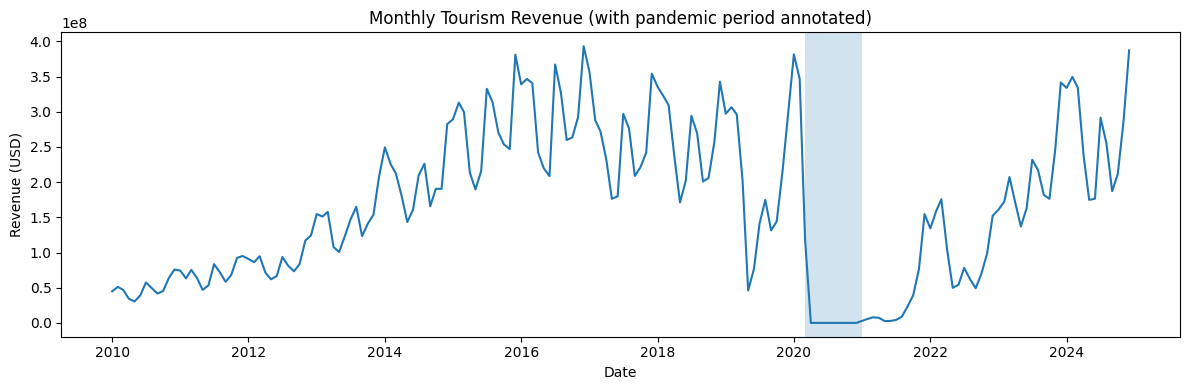

In [2]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['tourism_revenue_usd'])
plt.title('Monthly Tourism Revenue (with pandemic period annotated)')
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-12-31'), alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.tight_layout()
plt.show()

## 2) Drawdowns & worst declines

In [3]:
# Compute monthly percent change and drawdowns
rev = df.set_index('date')['tourism_revenue_usd'].replace(0, np.nan).fillna(method='ffill')
pct_change = rev.pct_change()
worst_declines = pct_change.nsmallest(10)
print('Top 10 monthly percent declines:')
print(worst_declines.head(10))

C:\Users\nimes\AppData\Local\Temp\ipykernel_19748\2149608236.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rev = df.set_index('date')['tourism_revenue_usd'].replace(0, np.nan).fillna(method='ffill')


Top 10 monthly percent declines:
date
2021-01-01   -0.975
2019-05-01   -0.773
2020-03-01   -0.659
2021-05-01   -0.641
2022-05-01   -0.520
2022-04-01   -0.409
2013-04-01   -0.317
2019-04-01   -0.315
2016-04-01   -0.289
2024-04-01   -0.289
Name: tourism_revenue_usd, dtype: float64


## 3) Rolling volatility (12-month)

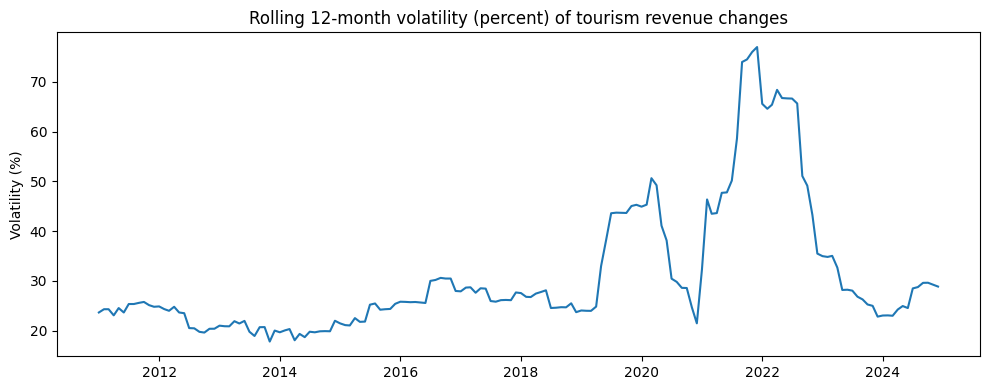

In [4]:
rolling_vol = pct_change.rolling(12).std() * 100
plt.figure(figsize=(10,4))
plt.plot(rolling_vol.index, rolling_vol)
plt.title('Rolling 12-month volatility (percent) of tourism revenue changes')
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.show()

## 4) Stress test: scenario where arrivals drop 50% for 6 months

Estimate impact on revenue using regression elasticity estimated earlier.

In [7]:
# Fit simple reg (if not already available)
import statsmodels.formula.api as smf
model_df = df[df['tourism_revenue_usd']>0].dropna(subset=['tourism_revenue_usd','tourist_arrivals','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd'])
reg = smf.ols('tourism_revenue_usd ~ tourist_arrivals + avg_stay + avg_daily_spend + hotel_occupancy_rate + exchange_rate_lkr_usd', data=model_df).fit()

# Pick a recent 6-month window as baseline
recent = model_df.tail(6).copy()
baseline_rev = recent['tourism_revenue_usd'].sum()
# apply 50% shock to arrivals
shocked = recent.copy()
shocked['tourist_arrivals'] = shocked['tourist_arrivals'] * 0.5
shocked['pred_rev'] = reg.predict(shocked[['tourist_arrivals','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd']])
shocked_rev = shocked['pred_rev'].sum()
print('Baseline 6-month revenue:', round(baseline_rev,2))
print('Shocked (50% arrivals) predicted 6-month revenue:', round(shocked_rev,2))
print('Revenue shortfall:', round(baseline_rev - shocked_rev,2))

Baseline 6-month revenue: 1620244863.71
Shocked (50% arrivals) predicted 6-month revenue: 859415714.63
Revenue shortfall: 760829149.08


## 5) Monte Carlo example (simple)

Simulate revenue under random shocks to arrivals and exchange rate and compute distribution of outcomes.

In [8]:
import numpy as np
# baseline features = mean of recent
baseline = model_df[['tourist_arrivals','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd']].mean()

def simulate_one(seed=None):
    rng = np.random.RandomState(seed)
    arr = rng.normal(baseline['tourist_arrivals'], baseline['tourist_arrivals']*0.15)  # 15% sigma
    exr = rng.normal(baseline['exchange_rate_lkr_usd'], baseline['exchange_rate_lkr_usd']*0.10)
    feat = baseline.copy()
    feat['tourist_arrivals']=arr
    feat['exchange_rate_lkr_usd']=exr
    return reg.predict(feat.to_frame().T)[0]

sims = [simulate_one(i) for i in range(1000)]
import statistics as stat
print('Simulated mean monthly revenue:', stat.mean(sims))
print('5th percentile:', np.percentile(sims,5))
print('95th percentile:', np.percentile(sims,95))

Simulated mean monthly revenue: 176001607.36949176
5th percentile: 134397693.29936212
95th percentile: 218500633.56440157


## 6) Precautions & Recommendations (practical)

- Diversify source markets (reduce concentration risk).  
- Build emergency liquidity/fund for tourism businesses.  
- Strengthen health & safety protocols to reduce closure risk.  
- Encourage flexible booking policies and travel insurance uptake.  
- Invest in domestic tourism during international downturns.  
- Promote digital marketing and alternative markets rapidly when shocks occur.